# Never gonna give you up
# Never gonna DRAG you down

Howdy folks. Today we'll be quantum mechanic.

In [1]:
# First we set up some basic dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import qiskit as qis
import qiskit.pulse as qisp
from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit import IBMQ, schedule
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.compiler.assembler import MeasLevel, MeasReturnType
from qiskit.tools.monitor import job_monitor

if not IBMQ.active_account():
    IBMQ.load_account()
    
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

In [59]:
qubit = 0
drive_freq = backend.configuration().hamiltonian['vars'][f'wq{qubit}']/(2*np.pi)
# drive_coupling = backend.configuration().hamiltonian['vars'][f'omegad{qubit}']

x_sigma = 80
x_duration = 320

x_amp = 0.10218341976411754
drive_betas = np.linspace(-20, 20, 33)

drive_beta = Parameter('drive_beta')
with qisp.build(backend=backend, default_alignment='sequential') as XX_sched:
        qisp.set_frequency(drive_freq, qisp.drive_channel(0))
        qisp.play(qisp.Drag(duration=x_duration,
                              amp=x_amp,
                              sigma=x_sigma,
                              beta=drive_beta), qisp.drive_channel(0))
        qisp.shift_phase(-np.pi, qisp.drive_channel(0))
        qisp.play(qisp.Drag(duration=x_duration,
                              amp=x_amp,
                              sigma=x_sigma,
                              beta=drive_beta), qisp.drive_channel(0))
        qisp.shift_phase(-np.pi, qisp.drive_channel(0))

In [60]:
n = 3
XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
qc_DRAG = QuantumCircuit(1, 1)
i = 0
while i < n:
    qc_DRAG.append(XX, [0])
    i += 1
qc_DRAG.measure(0, 0)
qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
exp_DRAG_circuits_n3 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

In [61]:
n = 5
XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
qc_DRAG = QuantumCircuit(1, 1)
i = 0
while i < n:
    qc_DRAG.append(XX, [0])
    i += 1
qc_DRAG.measure(0, 0)
qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
exp_DRAG_circuits_n5 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

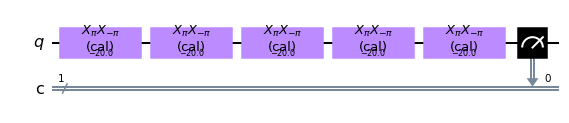

In [62]:
exp_DRAG_circuits_n5[0].draw(output='mpl')

In [63]:
# n = 7
n = 7
XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
qc_DRAG = QuantumCircuit(1, 1)
i = 0
while i < n:
    qc_DRAG.append(XX, [0])
    i += 1
qc_DRAG.measure(0, 0)
qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
exp_DRAG_circuits_n7 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

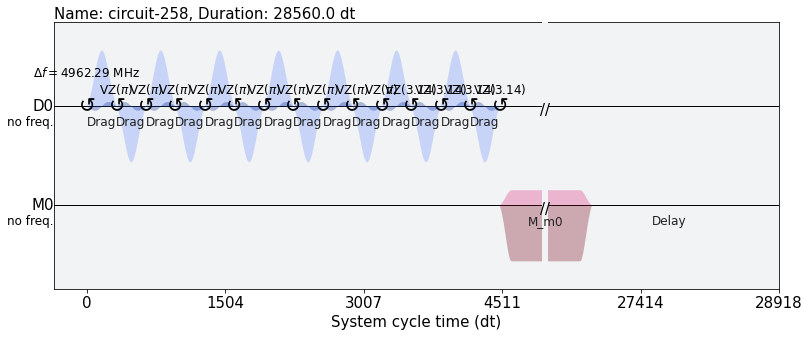

In [64]:
schedule(exp_DRAG_circuits_n7[7], backend).draw()

In [66]:
exp_DRAG_circuits = []
for i in exp_DRAG_circuits_n3:
    exp_DRAG_circuits.append(i)
for i in exp_DRAG_circuits_n5:
    exp_DRAG_circuits.append(i)
for i in exp_DRAG_circuits_n7:
    exp_DRAG_circuits.append(i)

In [67]:
drag_job = backend.run(exp_DRAG_circuits,
                       meas_level=1,
                       meas_return='avg',
                       shots=2**14)

In [68]:
print(drag_job.job_id())

6347ced56e2a62640efc5ae9


In [43]:
job_monitor(drag_job)

Job Status: job has successfully run


633d9ee5338f421278b75c38
6347bf3e6e2a625e9bfc5a8b (failed)

In [69]:
drag_job = backend.retrieve_job('6347ced56e2a62640efc5ae9')

In [ ]:
# def baselineRemover(values):
#     return np.array(values) - np.mean(values)
#
# num_beta_points = len(drive_betas)

In [70]:
drag_results = drag_job.result(timeout=120)
drag_values = []
for i in range(99):
    drag_values.append(drag_results.get_memory(i)[qubit] * 1e-7)
drag_values = np.real(drag_values)

In [71]:
drag_values

array([ 1.8978168 ,  2.0360478 ,  2.0798074 ,  1.9832838 ,  1.7657706 ,
        1.5012408 ,  1.1162738 ,  0.63259155,  0.1380591 , -0.38510665,
       -0.850732  , -1.3112209 , -1.685046  , -2.0171696 , -2.2111418 ,
       -2.3146158 , -2.3133698 , -2.198168  , -1.9393564 , -1.6691784 ,
       -1.2574932 , -0.8119833 , -0.32840847,  0.22743775,  0.68573415,
        1.1378838 ,  1.5081724 ,  1.8257132 ,  1.9926648 ,  2.0708844 ,
        2.0291146 ,  1.8803404 ,  1.6210902 , -2.1250314 , -1.7279176 ,
       -1.0069687 , -0.17863031,  0.6784668 ,  1.3753441 ,  1.8489828 ,
        2.0663    ,  1.9646272 ,  1.5181339 ,  0.9024027 ,  0.09866735,
       -0.7273931 , -1.4617754 , -2.0109998 , -2.3033454 , -2.2865872 ,
       -1.966736  , -1.3505799 , -0.60821095,  0.25201477,  0.9871858 ,
        1.6246448 ,  1.9854784 ,  2.0467366 ,  1.7907206 ,  1.2766543 ,
        0.5646874 , -0.3067996 , -1.0779219 , -1.7633012 , -2.2037446 ,
       -2.3329744 ,  0.73627045, -0.39947252, -1.4919216 , -2.15

In [72]:
drag_values_n3 = drag_values[0:33]
drag_values_n5 = drag_values[33:66]
drag_values_n7 = drag_values[66:99]

In [73]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)

    return fitparams, y_fit

In [76]:
def sinusoid(x, fit_params):
    A, B, drive_period, phi = fit_params
    return A*np.cos(2*np.pi*x/drive_period - phi) + B

-0.7007007007007005

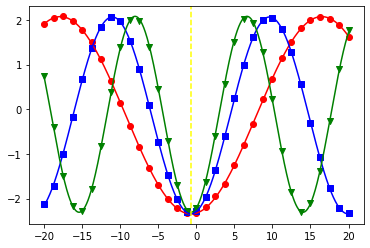

In [77]:
fit_params_n3, y_fit_n3 = fit_function(drive_betas,
                                       drag_values_n3,
                                       lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                       [2, 0, 40, 0])
fit_params_n5, y_fit_n5 = fit_function(drive_betas,
                                       drag_values_n5,
                                       lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                       [2, 0, 20, 0])
fit_params_n7, y_fit_n7 = fit_function(drive_betas,
                                       drag_values_n7,
                                       lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                       [2, 0, 20, 0])
x_val = np.linspace(-20, 20, 1000)
min_val = 1
beta_optimum = 0
for x in x_val:
    l = (sinusoid(x, fit_params_n3) + np.abs(fit_params_n3[0]) - fit_params_n3[1])**2 + (sinusoid(x, fit_params_n5) + np.abs(fit_params_n5[0]) - fit_params_n5[1])**2 + (sinusoid(x, fit_params_n7) + np.abs(fit_params_n7[0]) - fit_params_n7[1])**2
    if l < min_val:
        min_val = l
        x_optimum = x

plt.scatter(drive_betas, drag_values_n3, marker='o', linestyle='-', color='red')
plt.plot(x_val, sinusoid(x_val, fit_params_n3), color = 'red')
plt.scatter(drive_betas, drag_values_n5, marker='s', linestyle='-', color='blue')
plt.plot(x_val, sinusoid(x_val, fit_params_n5), color = 'blue')
plt.scatter(drive_betas, drag_values_n7, marker='v', linestyle='-', color='green')
plt.plot(x_val, sinusoid(x_val, fit_params_n7), color = 'green')
plt.axvline(x_optimum, linestyle='--', color='yellow')
# plt.xlim(-2, 2)
x_optimum

In [14]:
beta_optimum = x_optimum

In [15]:
with qisp.build(backend=backend, default_alignment='sequential') as SX_sched:
    qisp.set_frequency(drive_freq, qisp.drive_channel(0))
    qisp.play(qisp.Drag(duration=x_duration,
                        amp=x_amp/2,
                        sigma=x_sigma,
                        beta=beta_optimum), qisp.drive_channel(0))


In [13]:
SX_circs = []
for i in range(100):
    qc_SX = QuantumCircuit(1, 1)
    SX = Gate("$SX$", 1, [])
    qc_SX.add_calibration(SX, (0,), SX_sched, [])
    qc_SX.append(SX, [0])
    for j in range(i):
        qc_SX.append(SX, [0])
    qc_SX.measure(qubit, 0)
    SX_circs.append(qc_SX)

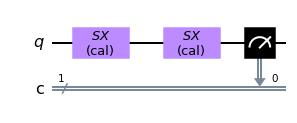

In [344]:
SX_circs[1].draw(output='mpl')

In [345]:
len(SX_circs)

100

In [346]:
SX_job = backend.run(SX_circs,
                    meas_level=2,
                    meas_return='single',
                    shots=2**14)
SX_job.job_id()

'633f8983e212b028d4beef0c'

In [117]:
job_monitor(SX_job)

Job Status: job is queued (156)

KeyboardInterrupt: 

# SX job
633ea125feb64c920ea00369: -1.3013013013013008
633f8983e212b028d4beef0c: -0.6206206206206204


In [14]:
SX_job = backend.retrieve_job('633f8983e212b028d4beef0c')

In [15]:
SX_results = SX_job.result().get_counts()

In [16]:
zero_population = [SX_results[i]['0']/2**14 for i in range(100)]
len(zero_population)

100

In [162]:
def SX_theory(val, epsilon):
    # return [1/2 + 1/2*np.cos(n*(np.pi/2 + epsilon)) for n in val]
    return [np.cos(n*(np.pi/2 + epsilon)/2)**2 for n in val]


[0.04397003]


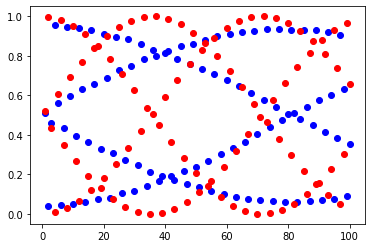

In [159]:
exp_num = [i + 1  for i in range(100)]

SX_params, SX_fit = fit_function(range(100),
                                       zero_population,
                                       SX_theory,
                                       [0.02])
print(SX_params)
plt.scatter(exp_num, zero_population, marker='o', linestyle='-', color='blue')
# plt.plot(range(100), SX_theory(range(100), SX_params), color='red')
# plt.xlim([0, 20])
plt.scatter(exp_num, SX_theory(exp_num, SX_params), color='red')

(0.0, 20.0)

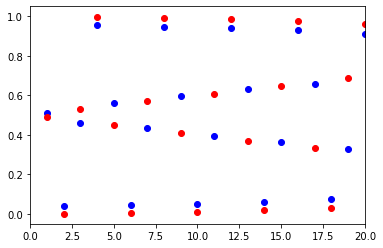

In [163]:
plt.scatter(exp_num, zero_population, marker='o', linestyle='-', color='blue')
plt.scatter(exp_num, SX_theory(exp_num, 0.02), color='red')
plt.xlim(0, 20)

In [18]:
SX_odd_circs = []
for i in range(100):
    qc_SX = QuantumCircuit(1, 1)
    SX = Gate("$SX$", 1, [])
    qc_SX.add_calibration(SX, (0,), SX_sched, [])
    qc_SX.append(SX, [0])
    for j in range(i):
        qc_SX.append(SX, [0])
        qc_SX.append(SX, [0])
    qc_SX.measure(qubit, 0)
    SX_odd_circs.append(qc_SX)


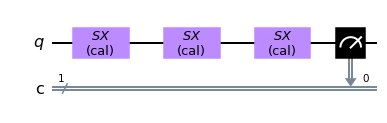

In [351]:
SX_odd_circs[1].draw(output='mpl')

In [266]:
SX_odd_job = backend.run(SX_odd_circs,
                     meas_level=2,
                     meas_return='single',
                     shots=2**14)
SX_odd_job.job_id()

'633ebe58338f42c077b76051'

In [19]:
SX_odd_job = backend.retrieve_job('633ebe58338f42c077b76051')

In [21]:
SX_odd_results = SX_odd_job.result().get_counts()
zero_population_odd = [SX_odd_results[i]['0']/2**14 for i in range(100)]

In [151]:
def SX_odd_theory(val, A, B, epsilon):
    # return [1/2 + 1/2*(-1)**n*np.cos(np.pi/2 + (2*n + 1)*epsilon) for n in val] #sheldon 2015
    return [A + B*np.cos((2*n + 1)*(epsilon + np.pi/2)) for n in val]
    # return [np.cos((epsilon + np.pi/2)*(n + 1/2))**2 for n in val]

In [169]:
num_fit = 78
exp_num = [i + 1  for i in range(100)]
SX_odd_params = curve_fit(SX_odd_theory, exp_num[:num_fit], zero_population_odd[:num_fit], p0 = [1/2, 1/2, 0.02], maxfev=5000)[0]
print(SX_odd_params)
residuals = [zero_population_odd[i] - SX_odd_theory(exp_num[i], *SX_odd_params) for i in range(num_fit)]
ss_res = np.sum(residuals**2)
ss_tot = np.sum((zero_population_odd[:num_fit]-np.mean(zero_population_odd[:num_fit]))**2)
r_squared = 1 - (ss_res / ss_tot)
print('r-squared =', r_squared)

plt.scatter(exp_num[:num_fit], zero_population_odd[:num_fit], marker='o', linestyle='-', color='blue')
# plt.plot(range(75), zero_population_odd[:75], marker='o', linestyle='-', color='blue')
# plt.xlim(0,10)

plt.scatter(exp_num[:num_fit], SX_odd_theory(range(num_fit), *SX_odd_params), color='red')

[0.50823087 0.4525394  0.02019534]


TypeError: 'int' object is not iterable

TypeError: SX_odd_theory() missing 2 required positional arguments: 'B' and 'epsilon'

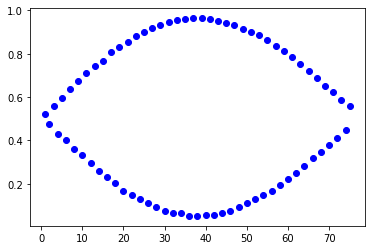

In [168]:
plt.scatter(exp_num[:75], zero_population_odd[:75], marker='o', linestyle='-', color='blue')
plt.scatter(exp_num[:75], SX_odd_theory(exp_num[:75], 0.02), color='red')
# plt.xlim(0, 10)